In [1]:
import os
from os import walk

import pandas as pd
import numpy as np
import sys
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import *

import numpy as np
import seaborn as sns

from collections import Counter

%matplotlib inline

pd.set_option('display.max_rows', 9000)
pd.set_option('display.max_columns', 1500)
pd.set_option('max_colwidth', 400)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))


#Set seaborn color palette:
my_pal = {'Kourami' : sns.color_palette("tab10")[0], 'HLA*LA' : sns.color_palette("tab10")[1], 'Optitype' : sns.color_palette("tab10")[2], 'HISAT-genotype' : sns.color_palette("tab10")[3], 'STC-Seq' : sns.color_palette("tab10")[4], 'Full Dataset' : sns.color_palette("tab10")[5]} 

In [2]:
main_folder_path = 'C:\\Users\\nikol\\OneDrive\\DTU\\11_semester\\'

In [3]:
# #Choose between 221 samples above 100X or the 14 samples above 200X
# high_coverage = True
high_coverage = False

high_coverage_id_list = ['HG00731', 'HG00732', 'HG01756', 'HG01757', 'HG01872', 'HG01873', 'HG01886', 'HG01953', 'HG01968','HG02014', 'HG02057', 'NA18912', 'NA19648', 'NA20313']

In [4]:
resolution_list = ["one_field", "two_field", "p_group", "e_group"]

coverage_list = [100, 75, 50, 20, 10, 5, 2, 1]

In [5]:
#Overall result dataframe:

downsample_res_dict_of_dfs = dict()


for coverage in coverage_list: 
    downsample_res_dict_of_dfs[coverage] = dict()
    
    for resolution in resolution_list:
        downsample_res_dict_of_dfs[coverage][resolution] = dict()
        
        #Read result dataframes
        result_df = pd.read_pickle(main_folder_path + "result_dataframes\\" + resolution + "_results_df_" + str(coverage) + "X.pkl")
        errors_metadata_hla_I_df = pd.read_pickle(main_folder_path + "result_dataframes\\" + resolution + "_errors_metadata_hla_I_df_" + str(coverage) + "X.pkl")
        errors_metadata_hla_II_df = pd.read_pickle(main_folder_path + "result_dataframes\\" + resolution + "_errors_metadata_hla_II_df_" + str(coverage) + "X.pkl")

        #Rename columns:
        result_df.rename(columns = {'HLA-LA':'HLA*LA', 'Hisatgenotype':'HISAT-genotype', 'STC-seq': 'STC-Seq'}, inplace=True)
        errors_metadata_hla_I_df.rename(columns = {'HLA-LA':'HLA*LA', 'Hisatgenotype':'HISAT-genotype', 'STC-seq': 'STC-Seq'}, inplace=True)
        errors_metadata_hla_II_df.rename(columns = {'HLA-LA':'HLA*LA', 'Hisatgenotype':'HISAT-genotype', 'STC-seq': 'STC-Seq'}, inplace=True)


        
        #Insert dataframes in dict of dict of dataframes
        downsample_res_dict_of_dfs[coverage][resolution]['result_df'] =  result_df
        downsample_res_dict_of_dfs[coverage][resolution]['errors_metadata_hla_I_df'] = errors_metadata_hla_I_df
        downsample_res_dict_of_dfs[coverage][resolution]['errors_metadata_hla_II_df'] = errors_metadata_hla_II_df

In [6]:
downsample_res_dict_of_dfs[100]

{'one_field': {'result_df': Tool    Kourami                            HLA*LA                           \
  Metric    score   count call_rate accuracy  score count call_rate accuracy   
  A         452.0   456.0     99.13    98.26    458   460     100.0    99.57   
  B         430.0   442.0     96.09    93.48    456   460     100.0    99.13   
  C         448.0   452.0     98.26    97.39    459   460     100.0    99.78   
  DRB1      453.0   460.0    100.00    98.48    455   460     100.0    98.91   
  DQB1      335.0   360.0     78.26    72.83    451   460     100.0    98.04   
  HLA-I    1330.0  1350.0     97.83    96.38   1373  1380     100.0    99.49   
  HLA-II    788.0   820.0     89.13    85.65    906   920     100.0    98.48   
  Evaxion  1783.0  1810.0     98.37    96.90   1828  1840     100.0    99.35   
  Total    2118.0  2170.0     94.35    92.09   2279  2300     100.0    99.09   
  
  Tool    Optitype                            HISAT-genotype                    \
  Metric 

In [7]:
# labels1 = ['Kourami', 'HLA-LA', 'Optitype', 'Hisatgenotype', 'STC-seq', 'ensemble_all', 'ensemble_graph']
# labels2 = ['Kourami', 'HLA-LA', 'Hisatgenotype', 'STC-seq', 'ensemble_graph']

labels1 = ['Kourami', 'HLA*LA', 'Optitype', 'HISAT-genotype', 'STC-Seq']
labels2 = ['Kourami', 'HLA*LA', 'HISAT-genotype', 'STC-Seq']

idx = pd.IndexSlice

def performance_coverage_plot(resolution = 'g_group', allele_index = 'All genes'):
    """
    resolution:    One of four options: ['two_field', 'g_group', 'p_group', 'e_group']
    allele index:  Either specific gene ['A', 'B', 'C', 'DRB1', 'DQB1'] or a group ['HLA-I', 'HLA-II', 'Evaxion', 'Total']
    
    """
    
    accuracy_dict = dict()

    for cov in coverage_list:

        results_df = downsample_res_dict_of_dfs[cov][resolution]['result_df']

        if allele_index in ('HLA-II', 'DRB1', 'DQB1'):
            call_rate = list(results_df.loc[allele_index, idx[labels2, 'call_rate']])

            accuracy_dict[cov] = list(results_df.loc[allele_index, idx[labels2, 'accuracy']])

        else:
            call_rate = list(results_df.loc[allele_index, idx[labels1, 'call_rate']])

            accuracy_dict[cov] = list(results_df.loc[allele_index, idx[labels1, 'accuracy']])

    accuracy_df = pd.DataFrame(accuracy_dict)

    if allele_index in ('HLA-II', 'DRB1', 'DQB1'):
        accuracy_df["labels"] = labels2
    else:
        accuracy_df["labels"] = labels1


    accuracy_df = accuracy_df.set_index("labels", drop=True)
    accuracy_df = accuracy_df.T

    fig, ax = subplots()
    
    accuracy_df.plot(marker='o', figsize = (10,8), color = my_pal, ax=ax)
    
    ax.set_xlabel("Coverage/sequencing depth", size=14)
    ax.set_ylabel("Accuracy (%)", size=14)
    
    ax.set_xticks(coverage_list)
    ax.set_yticks(list(range(0,101,10)))
    
    ax.yaxis.grid()
    
    plt.rcParams.update({'font.size': 14})
    plt.rc('xtick', labelsize=14)
    plt.rc('ytick', labelsize=14)
    
    plt.title('Typing accuracy for gene group: '+allele_index+" in "+"2-field"+" resolution")
    
    legend = ax.legend()
    legend.texts[0].set_text("Kourami")

    
    return fig, ax, accuracy_df
    

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Typing accuracy for gene group: DRB1 in 2-field resolution'}, xlabel='Coverage/sequencing depth', ylabel='Accuracy (%)'>,
 labels  Kourami  HLA*LA  HISAT-genotype  STC-Seq
 100       97.61   97.83           91.30    60.00
 75        94.35   97.39           90.00    51.30
 50        85.65   95.22           84.13    36.52
 20        52.17   90.22           71.52     7.83
 10        15.72   77.07           55.68     1.97
 5          2.83   57.39           40.87     0.00
 2          0.43   33.70           29.78     0.00
 1          0.00   21.96           21.30     0.00)

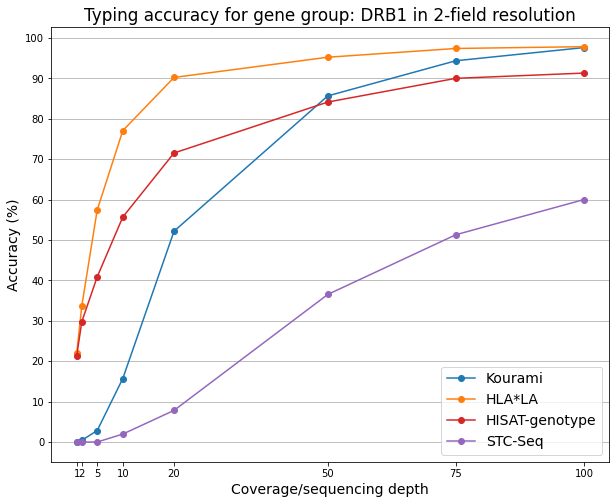

In [8]:
performance_coverage_plot(resolution = 'two_field', allele_index = "DRB1")

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Typing accuracy for gene group: HLA-II in 2-field resolution'}, xlabel='Coverage/sequencing depth', ylabel='Accuracy (%)'>,
 labels  Kourami  HLA*LA  HISAT-genotype  STC-Seq
 100       81.85   94.57           89.13    49.02
 75        77.17   92.93           85.76    41.85
 50        69.46   89.89           80.43    30.22
 20        42.72   83.26           69.67     6.96
 10        17.03   72.05           57.21     1.31
 5          4.35   56.96           44.57     0.00
 2          0.43   37.83           32.28     0.00
 1          0.00   27.28           24.78     0.00)

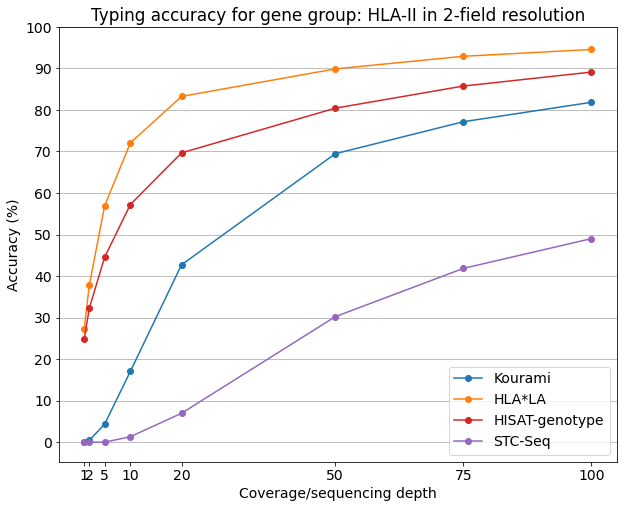

In [9]:
performance_coverage_plot(resolution = 'two_field', allele_index = "HLA-II")


# Time and memory use

In [10]:
#Load mean time and memory use for each tool for each coverage

#Load performance files:
memory_use_gb_dict = dict()
cpu_time_min_dict = dict()
wall_time_min_dict = dict()


for cov in coverage_list:
    
    memory_use_gb_dict[cov] = dict()
    cpu_time_min_dict[cov] = dict()
    wall_time_min_dict[cov] = dict()

    for tool in ['kourami', 'hla-la', 'optitype', 'hisatgenotype', 'stc-seq']:
        full_filepath =  main_folder_path + "output_" + str(cov) + "X\\1000_genomes_results\\" + tool

        #Make list of results for each tool:
        memory_use_list = list()
        cpu_time_list = list()
        wall_time_list = list()

        #Reset list of filenames for each tool
        tool_files = list()

        for (dirpath, dirnames, filenames) in walk(full_filepath):
            tool_files.extend(filenames)

        for file in tool_files:
            #Only include logfiles
            if file.endswith('.log'):
                with open(full_filepath + '\\' + file, 'r') as infile:
                    for line in infile:
                        #Grab memory use
                        if line.startswith('    resources_used.mem'):
                            line_extract = line.split()[-1][:-2]

                            memory_gb = int(line_extract)/(10**6)

                            memory_use_list.append(memory_gb)

                        #Grab cputime 
                        if line.startswith('    resources_used.cput'):
                            line_extract = line.split()[-1]

                            time_min = (int(line_extract[-8:-6]) * 60) + int(line_extract[-5:-3]) + (int(line_extract[-2:]) / 60)

                            cpu_time_list.append(time_min)

                        #Grab walltime
                        if line.startswith('    resources_used.walltime'):
                            line_extract = line.split()[-1]

                            time_min = (int(line_extract[-8:-6]) * 60) + int(line_extract[-5:-3]) + (int(line_extract[-2:]) / 60)

                            wall_time_list.append(time_min)
                    
#        Add mean or median to each dict:

        memory_use_gb_dict[cov][tool] = np.median(memory_use_list)
        cpu_time_min_dict[cov][tool] = np.median(cpu_time_list)
        wall_time_min_dict[cov][tool] = np.median(wall_time_list)
        
#         memory_use_gb_dict[cov][tool] = np.mean(memory_use_list)
#         cpu_time_min_dict[cov][tool] = np.mean(cpu_time_list)
#         wall_time_min_dict[cov][tool] = np.mean(wall_time_list)

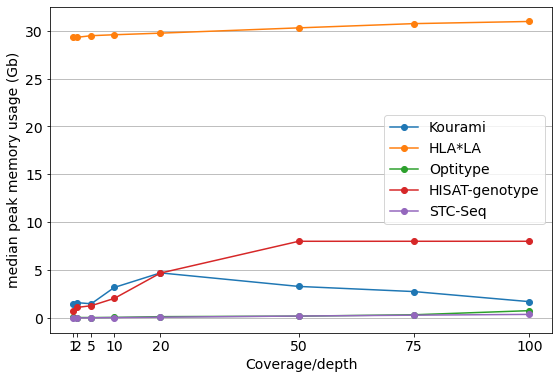

In [11]:
memory_df = pd.DataFrame(memory_use_gb_dict)

memory_df = memory_df.T

memory_df.rename(columns = {'kourami':'Kourami', 'hla-la':'HLA*LA', 'optitype':'Optitype', 'hisatgenotype':'HISAT-genotype', 'stc-seq': 'STC-Seq'}, inplace=True)

fig, ax = subplots()

memory_df.plot(marker='o', figsize = (9,6), ax=ax)

ax.set_xlabel("Coverage/depth")
ax.set_ylabel("median peak memory usage (Gb)")

ax.set_xticks(coverage_list)
# ax.set_yticks(list(range(0,101,10)))

ax.yaxis.grid()

plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

#plt.title("The effect of coverage on memory use for HLA typing")

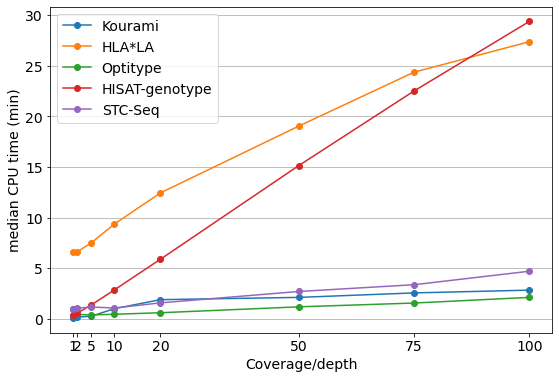

In [12]:
cpu_time_df = pd.DataFrame(cpu_time_min_dict)

cpu_time_df = cpu_time_df.T

cpu_time_df.rename(columns = {'kourami':'Kourami', 'hla-la':'HLA*LA', 'optitype':'Optitype', 'hisatgenotype':'HISAT-genotype', 'stc-seq': 'STC-Seq'}, inplace=True)


fig, ax = subplots()

cpu_time_df.plot(marker='o', figsize = (9,6), ax=ax)

ax.set_xlabel("Coverage/depth")
ax.set_ylabel("median CPU time (min)")

ax.set_xticks(coverage_list)
# ax.set_yticks(list(range(0,101,10)))

ax.yaxis.grid()

plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

#plt.title("The effect of coverage on required CPU time for HLA typing")

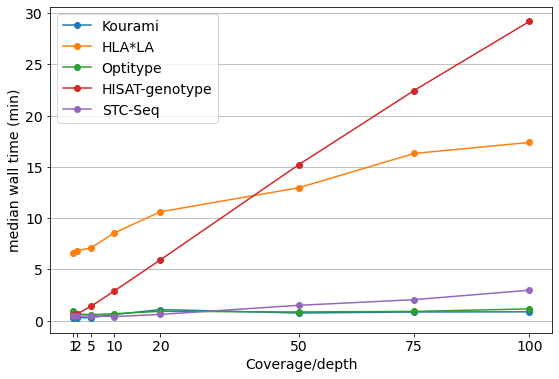

In [13]:
wall_time_df = pd.DataFrame(wall_time_min_dict)

wall_time_df = wall_time_df.T

wall_time_df.rename(columns = {'kourami':'Kourami', 'hla-la':'HLA*LA', 'optitype':'Optitype', 'hisatgenotype':'HISAT-genotype', 'stc-seq': 'STC-Seq'}, inplace=True)

fig, ax = subplots()

wall_time_df.plot(marker='o', figsize = (9,6), ax=ax)

ax.set_xlabel("Coverage/depth")
ax.set_ylabel("median wall time (min)")

ax.set_xticks(coverage_list)
# ax.set_yticks(list(range(0,101,10)))

ax.yaxis.grid()

# With log Y axis:

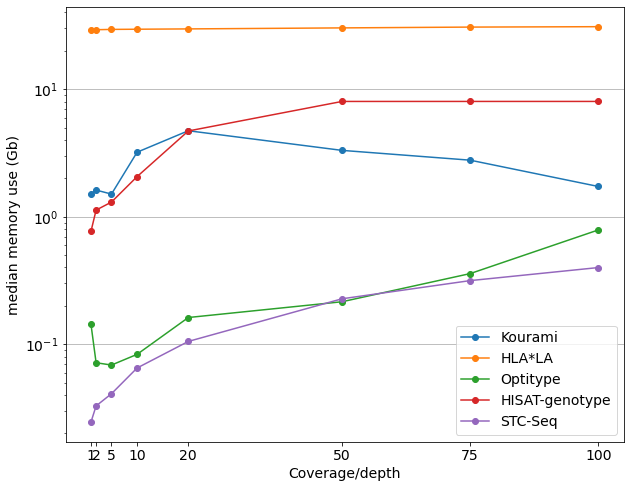

In [14]:
memory_df = pd.DataFrame(memory_use_gb_dict)

memory_df = memory_df.T

memory_df.rename(columns = {'kourami':'Kourami', 'hla-la':'HLA*LA', 'optitype':'Optitype', 'hisatgenotype':'HISAT-genotype', 'stc-seq': 'STC-Seq'}, inplace=True)


fig, ax = subplots()

memory_df.plot(marker='o', figsize = (10,8), ax=ax)

ax.set_xlabel("Coverage/depth")
ax.set_ylabel("median memory use (Gb)")

ax.set_xticks(coverage_list)
# ax.set_yticks(list(range(0,101,10)))
ax.set_yscale('log')
#ax.set_xscale('log')

ax.yaxis.grid()

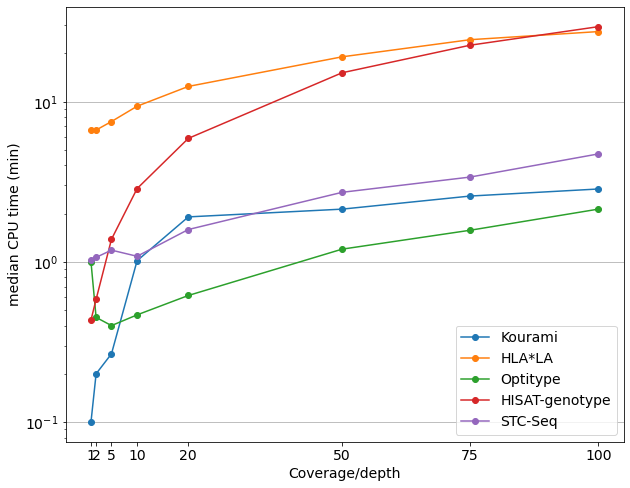

In [15]:
cpu_time_df = pd.DataFrame(cpu_time_min_dict)

cpu_time_df = cpu_time_df.T

cpu_time_df.rename(columns = {'kourami':'Kourami', 'hla-la':'HLA*LA', 'optitype':'Optitype', 'hisatgenotype':'HISAT-genotype', 'stc-seq': 'STC-Seq'}, inplace=True)


fig, ax = subplots()

cpu_time_df.plot(marker='o', figsize = (10,8), ax=ax)

ax.set_xlabel("Coverage/depth")
ax.set_ylabel("median CPU time (min)")

ax.set_xticks(coverage_list)
# ax.set_yticks(list(range(0,101,10)))
ax.set_yscale('log')
#ax.set_xscale('log')

ax.yaxis.grid()

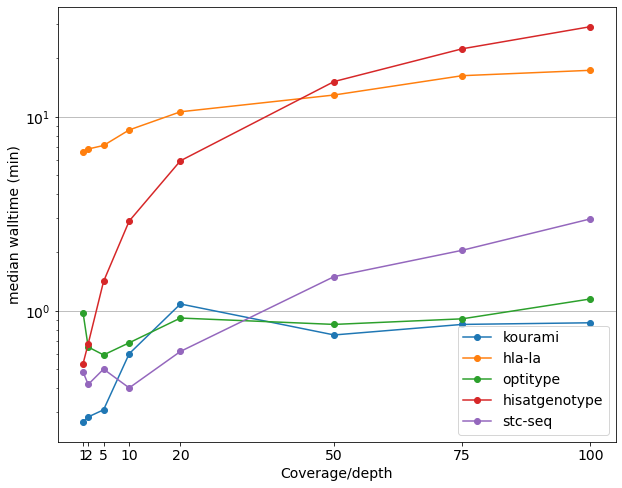

In [16]:
wall_time_df = pd.DataFrame(wall_time_min_dict)

wall_time_df = wall_time_df.T

fig, ax = subplots()

wall_time_df.plot(marker='o', figsize = (10,8), ax=ax)

ax.set_xlabel("Coverage/depth")
ax.set_ylabel("median walltime (min)")


# ax.set_yticks(list(range(0,101,10)))
ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xticks(coverage_list)

ax.yaxis.grid()